In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from scipy import stats
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
report = ProfileReport(data, title='Insurance Report', explorative=True)
report.to_widgets()

In [3]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
data.shape

(1338, 7)

In [11]:
for column in data.columns:
    col = data[column]
    
    print(f'"{column}" ',col.dtypes, 'unique values =', col.nunique())

"age"  int64 unique values = 47
"sex"  object unique values = 2
"bmi"  float64 unique values = 548
"children"  int64 unique values = 6
"smoker"  object unique values = 2
"region"  object unique values = 4
"charges"  float64 unique values = 1337


In [12]:
data.children = data.children.astype('object')
data.children.dtypes

dtype('O')

<Figure size 432x288 with 0 Axes>

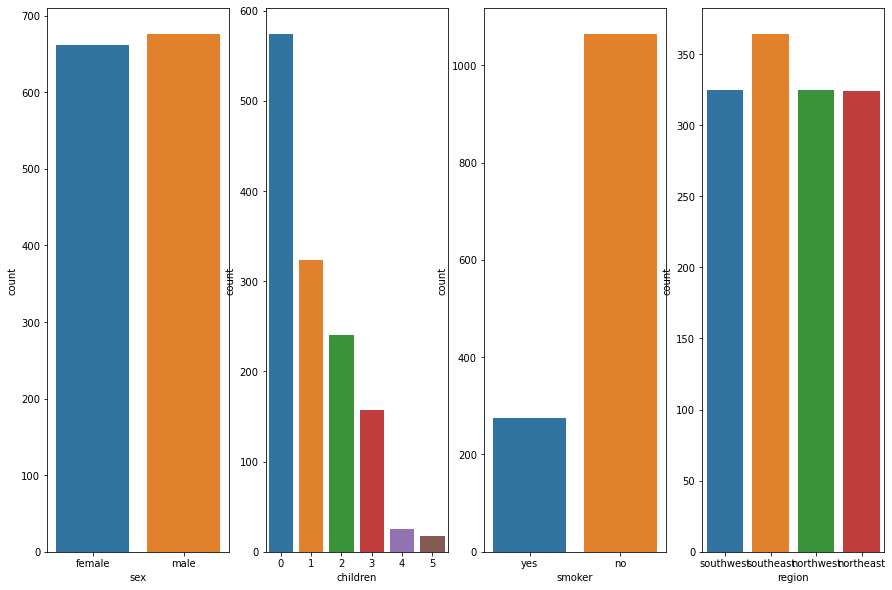

In [13]:
num = 0
plt.subplots_adjust(wspace = 0.1)
plt.figure(figsize=(15,10))
for column in data.columns:
    col = data[column]
    if col.dtypes == 'object':
        ax = plt.subplot(141 + num)
        ax = sns.countplot(x = col)
        num+=1

<Figure size 432x288 with 0 Axes>

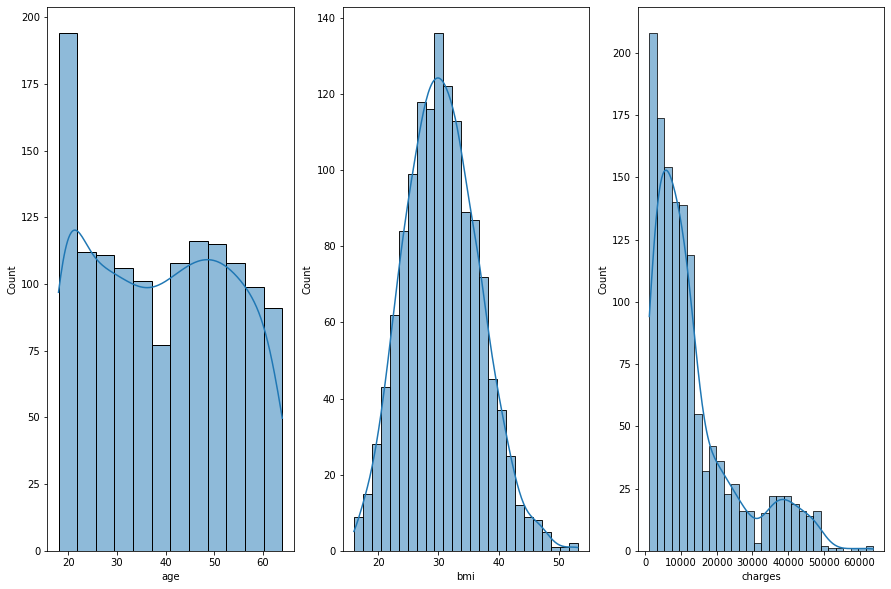

In [14]:
num = 0
plt.subplots_adjust(wspace = 0.3)
plt.figure(figsize=(15,10))
for column in data.columns:
    col = data[column]
    if col.dtypes != 'object':
        ax = plt.subplot(131 + num)
        ax = sns.histplot(col, kde=True)
        num+=1

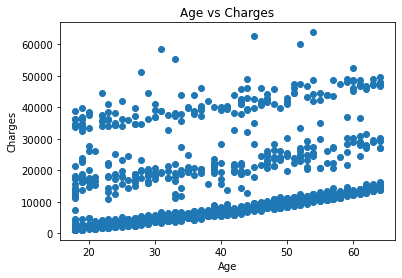

In [15]:
plt.scatter(data.age, data.charges)
plt.title("Age vs Charges")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.show()

<AxesSubplot:ylabel='Frequency'>

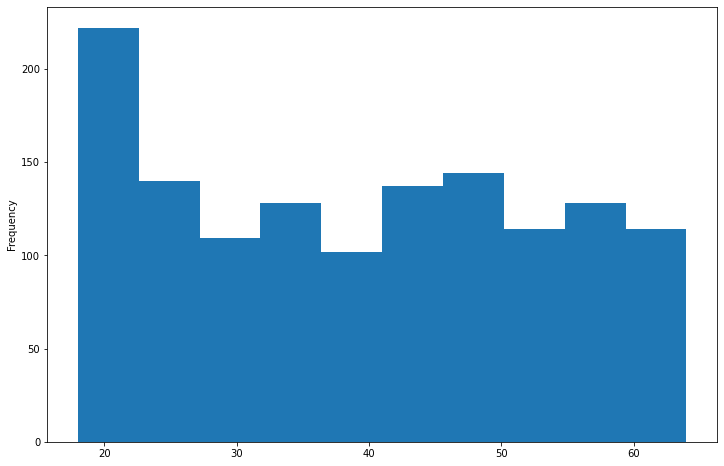

In [16]:
data.age.plot(x=data.index, kind='hist', stacked=False, figsize = (12, 8))

In [25]:
numerical_continuous = data.drop(['age', 'sex', 'children', 'smoker', 'region'], axis=1)
print(numerical_continuous)

         bmi      charges
0     27.900  16884.92400
1     33.770   1725.55230
2     33.000   4449.46200
3     22.705  21984.47061
4     28.880   3866.85520
...      ...          ...
1333  30.970  10600.54830
1334  31.920   2205.98080
1335  36.850   1629.83350
1336  25.800   2007.94500
1337  29.070  29141.36030

[1338 rows x 2 columns]


In [22]:
numerical_discrete = data.drop(['bmi', 'charges', 'sex', 'children', 'smoker', 'region'], axis=1)
numerical_discrete

,age
0,19
1,18
2,28
3,33
4,32
...,...
1333,50
1334,18
1335,18
1336,21


<Figure size 432x288 with 0 Axes>

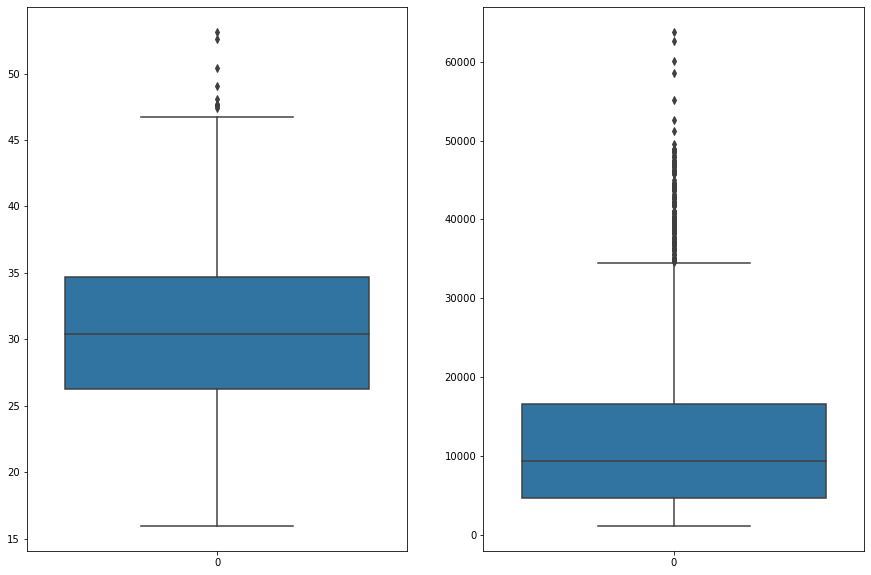

In [23]:
num = 0
plt.subplots_adjust(wspace = 0.5)
plt.figure(figsize=(15,10))
for column in numerical_continuous.columns:
    col = numerical_continuous[column]
    ax = plt.subplot(121 + num)
    ax = sns.boxplot(data=col)
    num+=1


In [27]:
data[['new_bmi', 'new_charges']]=np.abs(stats.zscore(numerical_continuous))

<AxesSubplot:>

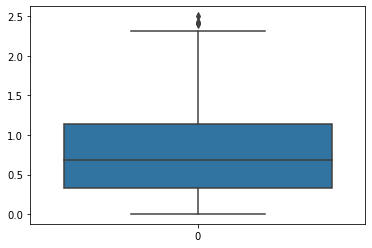

In [34]:
newdata=data[(data["new_charges"]< 1.5)]

newdata=newdata[(newdata["new_bmi"]< 2.5)]


sns.boxplot(data=newdata.new_bmi)

In [36]:
newdata.isna().sum()

age            0
sex            0
bmi            0
children       0
smoker         0
region         0
charges        0
new_bmi        0
new_charges    0
dtype: int64

In [37]:
for label, content in newdata.items():
    if not pd.api.types.is_numeric_dtype(content):
        newdata[label] = pd.Categorical(content).codes + 1

C:\Users\tONy\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [39]:
X = newdata[['age', 'sex', 'new_bmi', 'children', 'smoker', 'region']]
Y = newdata[['new_charges']]


      age  sex   new_bmi  children  smoker  region
0      19    1  0.453320         1       2       4
1      18    2  0.509621         2       1       3
2      28    2  0.383307         4       1       3
3      33    2  1.305531         1       1       2
4      32    2  0.292556         1       1       2
...   ...  ...       ...       ...     ...     ...
1333   50    2  0.050297         4       1       2
1334   18    1  0.206139         1       1       1
1335   18    1  1.014878         1       1       3
1336   21    1  0.797813         1       1       4
1337   61    1  0.261388         1       2       2

[1170 rows x 6 columns]       new_charges
0        0.298584
1        0.953689
2        0.728675
3        0.719843
4        0.776802
...           ...
1333     0.220551
1334     0.914002
1335     0.961596
1336     0.930362
1337     1.311053

[1170 rows x 1 columns]


In [40]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)

model.fit(X, Y)

C:\Users\tONy\AppData\Local\Temp\ipykernel_13352\2703300595.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X, Y)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [41]:
model.score(X, Y)

0.9440528983297709